# Работа на паре

In [218]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs 
import pandas as pd

In [219]:
# Generate sample data
n_samples = 4000
n_components = 4

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0
)
X = X[:, ::-1]

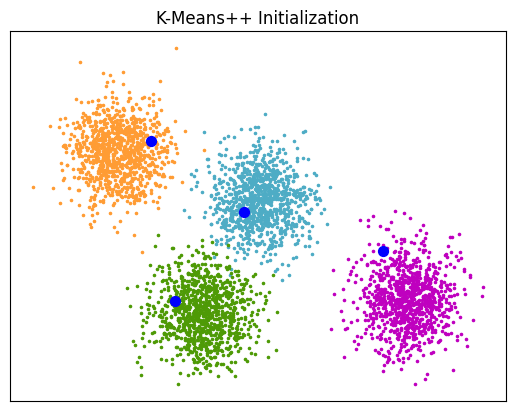

In [220]:
# Calculate seeds from kmeans++
centers_init, indices = kmeans_plusplus(X, n_clusters=4,
                                        random_state=0)

# Plot init seeds along side sample data
plt.figure(1)
colors = ['#4EACC5', '#FF9C34', '#4E9A06', 'm']

for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1],
                c=col, marker='.', s=10)

plt.scatter(centers_init[:, 0], centers_init[:, 1], c='b', s=50)
plt.title("K-Means++ Initialization")
plt.xticks([])
plt.yticks([])
plt.show()

# Реализовать метод к-means вручную

In [221]:
data = pd.DataFrame(data=X)

In [222]:
data

,0,1
0,2.525110,-1.508248
1,7.468238,-2.286283
2,2.107254,-0.468814
3,7.114966,-1.163047
4,8.696331,-0.846592
...,...,...
3995,4.136209,0.682435
3996,3.913172,1.490368
3997,0.000417,2.120557
3998,2.382659,-1.129934


In [223]:
#функция определния центроидов - рандомные точки
def initiate_centroids(k, dset):
    centroids = dset.sample(k)
    return centroids

In [224]:
#выбор центроидов
np.random.seed(1)
k=4
centroids = initiate_centroids(k, data)
centroids #это предполагаемы центры наших кластеров

,0,1
200,7.255887,-1.236386
1078,5.321369,2.469335
610,1.895988,3.200873
2159,1.620424,2.138111


In [225]:
#определение функции потерь, то есть сумма расстояний от точек по центроидов
def rsserr(a,b):
    return np.square(np.sum((a-b)**2)) 

In [226]:
#вывод ошибок по каждому "кластеру"
for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], data.iloc[0,:])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))

Error for centroid 0: 504.19
Error for centroid 1: 558.86
Error for centroid 2: 509.48
Error for centroid 3: 199.22


In [227]:
#теперь нужно написать функцию, которая бы присвоила каждому значению в данных номер центроида к какому он относится
def centroid_assignation(dset, centroids):
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for i in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[i,:]) #функция потерь
            all_errors = np.append(all_errors, err)

        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0] #ищем минимальную ошибку расстояния между данными и центроидом
        nearest_centroid_error = np.amin(all_errors)

        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

In [228]:
#добавим два дополнительных столбца с величиной центроида и величиной ошибки
data['centroid'], data['error'] = centroid_assignation(data, centroids)
data.head()

,0,1,centroid,error
0,2.525110,-1.508248,3,199.215837
1,7.468238,-2.286283,0,1.316471
2,2.107254,-0.468814,3,49.463937
3,7.114966,-1.163047,0,0.000637
4,8.696331,-0.846592,0,4.958715


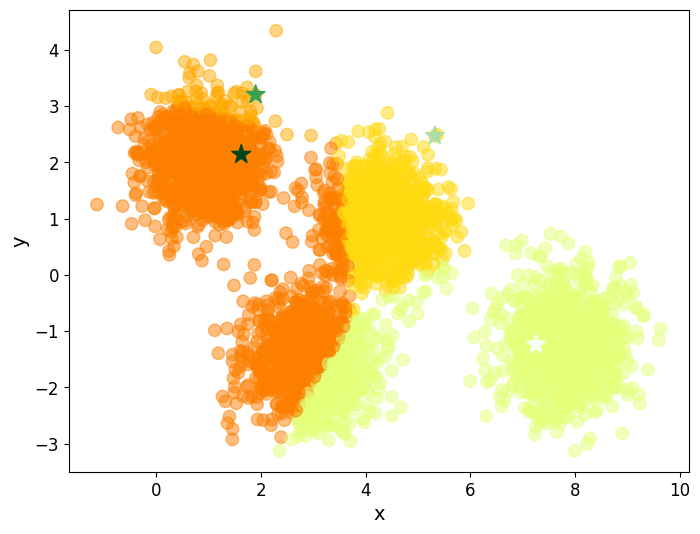

In [229]:
#Посмотрим на визуализацию полученного результата
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', c=data['centroid'].astype('category'), 
            cmap = 'Wistia', s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = '*', s=200, c=[0, 1, 2, 3], 
            cmap = 'Greens')
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [230]:
centroids = data.groupby('centroid').agg('mean').loc[:, ].reset_index(drop = True)
centroids

,0,1,error
0,6.748594,-1.377616,58.368177
1,4.412991,0.999155,15.888308
2,1.204156,3.115380,2.074617
3,1.745688,0.564303,83.037770


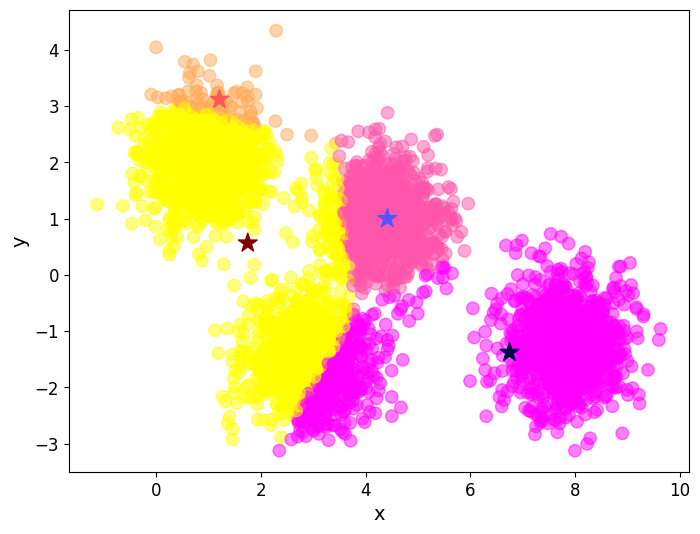

In [231]:
#значения немного поменялись, но это всё равно не совсем то. Менять положение центроида надо каждый раз, а не только в конце
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', 
            c=data['centroid'].astype('category'), 
            cmap = 'spring', s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = '*', s=200,
            c=[0, 1, 2, 3], cmap = 'seismic')
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [232]:
def kmeans(dset, k=4, tol=1e-4):
    working_dset = dset.copy() #работаем с копией датасета
    err = []
    goahead = True
    j = 0
    # назначаем кластеры, выбрав центроиды
    centroids = initiate_centroids(k, dset)
    
    while(goahead):
        #присваиваем точкам номер центроида и считаем ошибки
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # изменяем положение центроила на среднее значение по ним
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # запускаем всё заново если мы не достигли нужной ошибки
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    
    return working_dset['centroid'], j_err, centroids

In [233]:
data.columns

Index([0, 1, 'centroid', 'error'], dtype='object')

In [234]:
np.random.seed(42)
data['centroid'], data['error'], centroids =  kmeans(data[[0, 1]], 4)
data.head()

,0,1,centroid,error
0,2.525110,-1.508248,0,0.023824
1,7.468238,-2.286283,1,1.486750
2,2.107254,-0.468814,0,3.132140
3,7.114966,-1.163047,1,0.246153
4,8.696331,-0.846592,1,0.863734


In [235]:
data['centroid'].value_counts()

centroid
0    1002
1    1000
2    1000
3     998
Name: count, dtype: int64

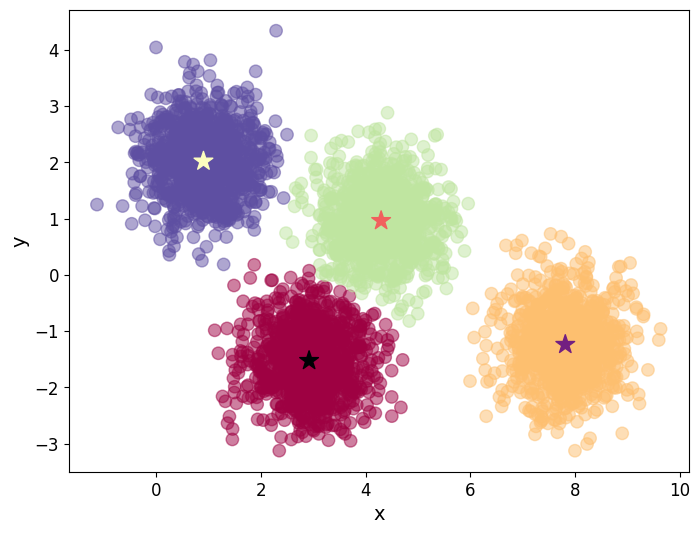

In [236]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(data.iloc[:,0], data.iloc[:,1],  marker = 'o', 
            c=data['centroid'].astype('category'), 
            cmap = 'Spectral', s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = '*', s=200, c=[0, 1, 2, 3], 
            cmap = 'magma')
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()